In [131]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima




In [56]:
def get_stock_data(ticker):
    stock = yf.download(ticker)
    return stock.dropna()

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
stock_data = {ticker: get_stock_data(ticker) for ticker in tickers}
aapl = stock_data['AAPL']
aapl

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099450,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094261,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087343,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089504,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092099,73449600
...,...,...,...,...,...,...
2023-09-14,174.000000,176.100006,173.580002,175.740005,175.740005,60895800
2023-09-15,176.479996,176.500000,173.820007,175.009995,175.009995,109205100
2023-09-18,176.479996,179.380005,176.169998,177.970001,177.970001,67257600


## Visualise the data for AAPL

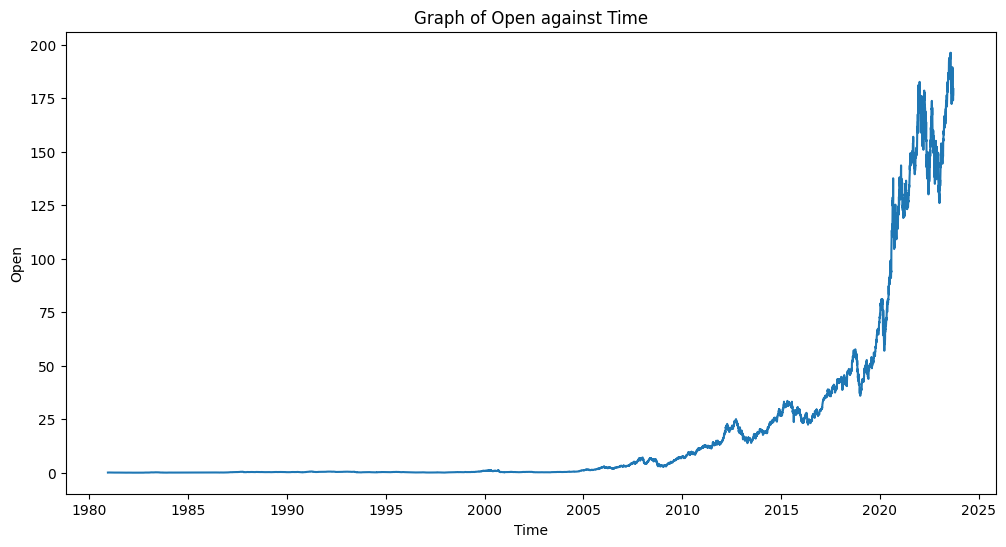

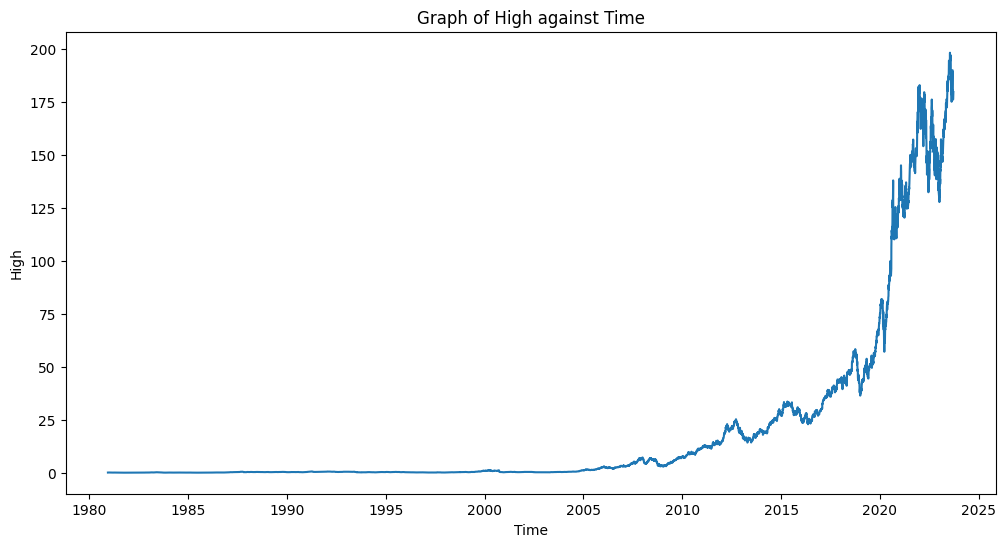

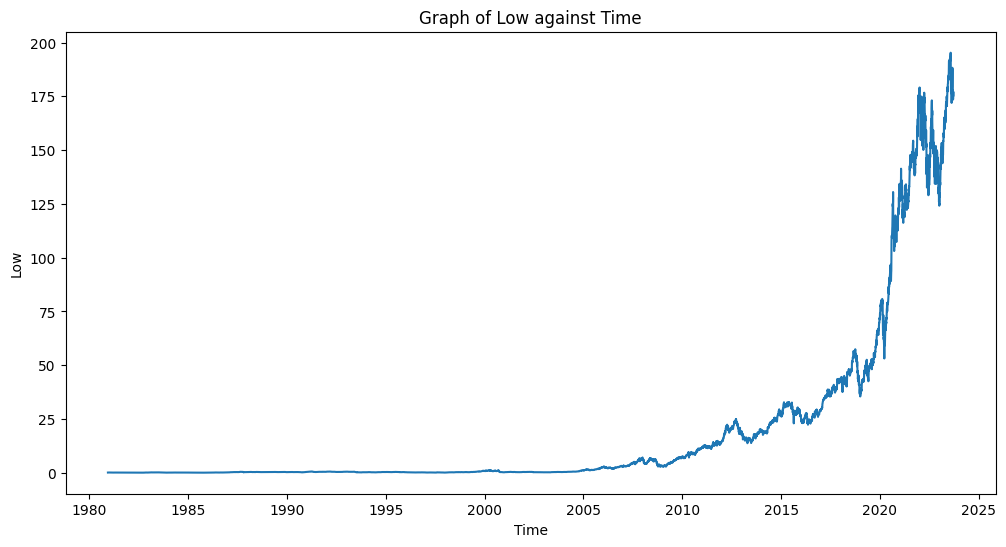

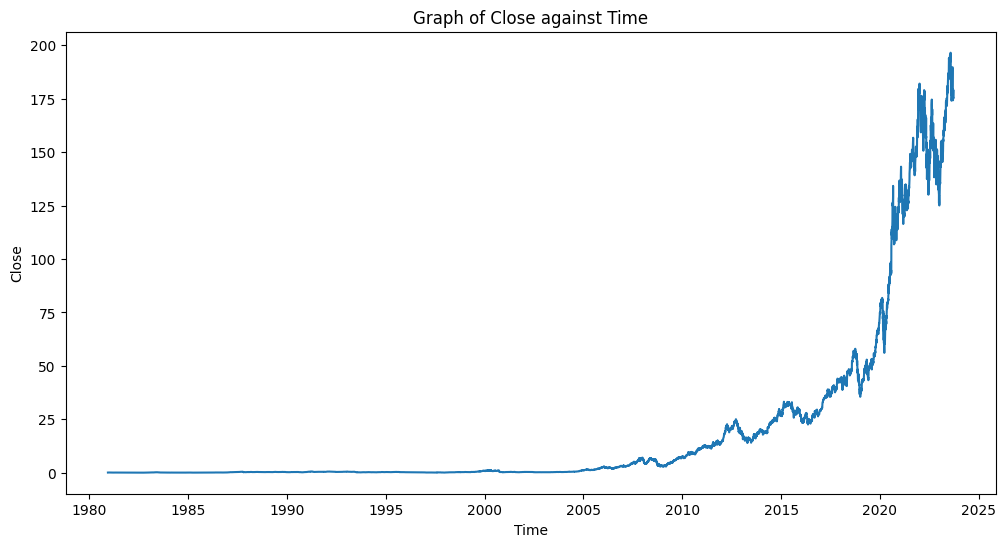

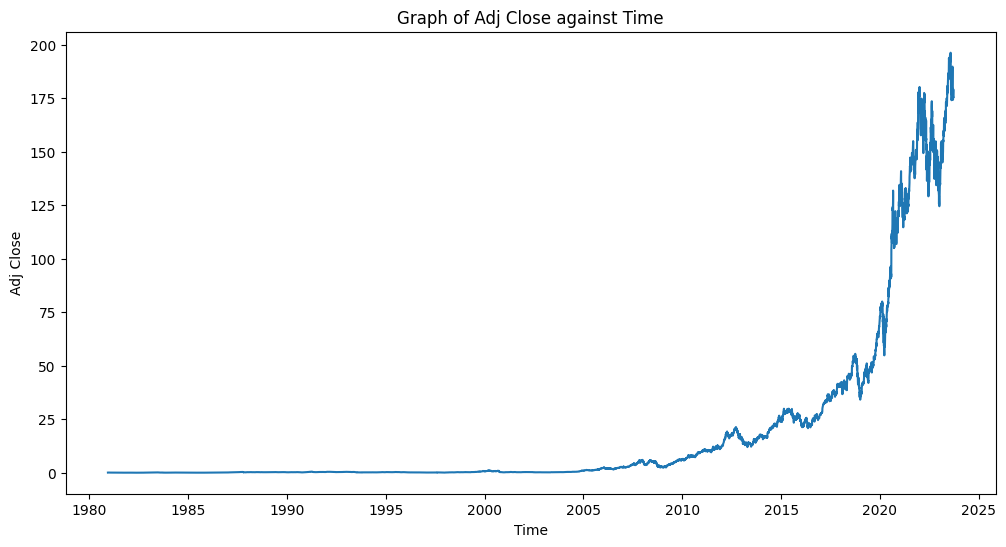

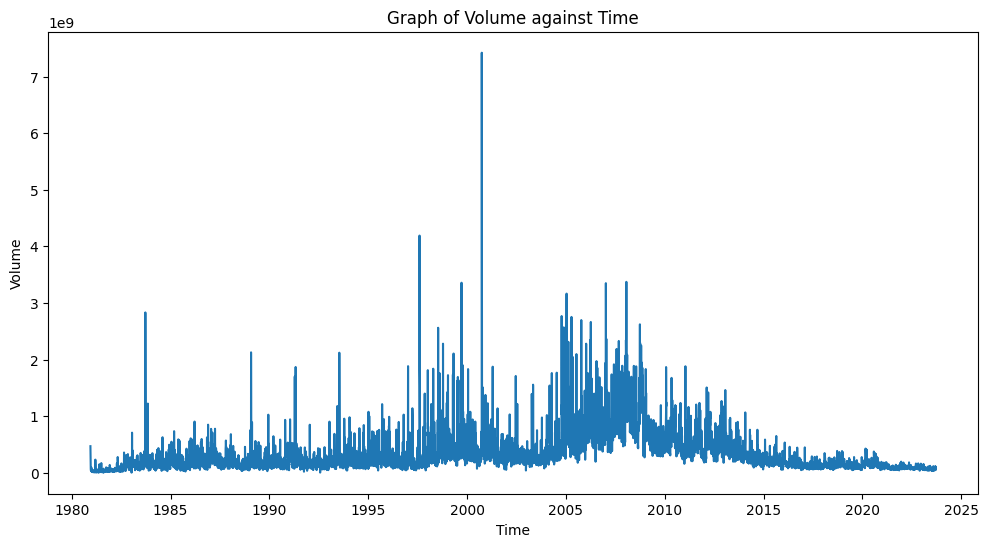

In [57]:
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
for feature in features:
    plt.figure(figsize=(12,6))
    plt.plot(aapl[feature])
    plt.title(f"Graph of {feature} against Time")
    plt.xlabel("Time")
    plt.ylabel(f'{feature}')
plt.show()

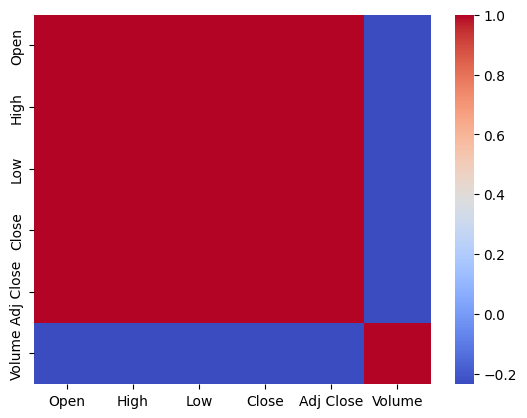

In [58]:
corr_matrix = aapl.corr()
heatmap = sns.heatmap(corr_matrix, cmap="coolwarm")

### I noticed that there is a high degree of multicollinearity between the different features, this will cause problems. As such, I will be performing predictions on Adj Close Price solely based on Adj Close Price values.

In [59]:
# Handle missing rows
aapl_full = aapl
full_range = pd.date_range(start=aapl_full.index.min(), end=aapl_full.index.max(), freq='D')
aapl_full = aapl_full.reindex(full_range)
aapl_full.index = pd.DatetimeIndex(aapl_full.index, freq='D')
# Handle nan values
for feature in features:
    aapl_full[feature].interpolate(method='linear', inplace=True)
aapl_full


,Open,High,Low,Close,Adj Close,Volume
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099450,4.690336e+08
1980-12-13,0.126302,0.126674,0.126116,0.126116,0.097720,3.713173e+08
1980-12-14,0.124256,0.124442,0.123884,0.123884,0.095991,2.736011e+08
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094261,1.758848e+08
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087343,1.057280e+08
...,...,...,...,...,...,...
2023-09-16,176.479996,177.460002,174.603338,175.996663,175.996663,9.522260e+07
2023-09-17,176.479996,178.420003,175.386668,176.983332,176.983332,8.124010e+07
2023-09-18,176.479996,179.380005,176.169998,177.970001,177.970001,6.725760e+07
2023-09-19,177.520004,179.630005,177.130005,179.070007,179.070007,5.182690e+07


In [60]:
# Normalizing the data
date_range = aapl_full.index
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(aapl_full)
df_scaled = pd.DataFrame(data_normalized, columns = aapl_full.columns, index=date_range)
df_scaled

,Open,High,Low,Close,Adj Close,Volume
1980-12-12,0.000401,0.000400,0.000406,0.000403,0.000313,0.063198
1980-12-13,0.000391,0.000389,0.000394,0.000392,0.000304,0.050032
1980-12-14,0.000380,0.000377,0.000383,0.000381,0.000295,0.036865
1980-12-15,0.000370,0.000366,0.000372,0.000369,0.000287,0.023699
1980-12-16,0.000324,0.000321,0.000326,0.000324,0.000251,0.014246
...,...,...,...,...,...,...
2023-09-16,0.899281,0.895196,0.894091,0.895859,0.897075,0.012830
2023-09-17,0.899281,0.900041,0.898104,0.900883,0.902105,0.010946
2023-09-18,0.899281,0.904885,0.902116,0.905907,0.907136,0.009062
2023-09-19,0.904582,0.906146,0.907033,0.911508,0.912744,0.006983


Here I investigated the effect of (order of differencing, d) for d = 0, 1 and 2

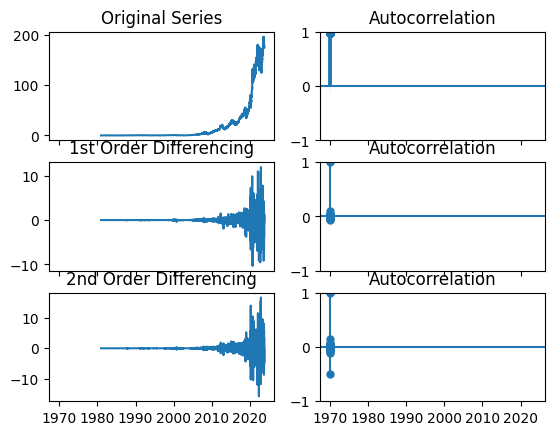

In [138]:
endog_variable = "Adj Close"
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(aapl_full[endog_variable]); axes[0, 0].set_title('Original Series')
plot_acf(aapl_full[endog_variable], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(aapl_full[endog_variable].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(aapl_full[endog_variable].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(aapl_full[endog_variable].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(aapl_full[endog_variable].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Here, I trained the model using the entire dataset to look at the predictions generated by the model, to get a base idea of the train MSE.

In [61]:

# exog_variable = ["Open", "High", "Low"]
model = ARIMA(df_scaled[endog_variable], order = (1, 1, 1))
model_fit = model.fit()
model_fit.summary()
start, end = "1980-12-12", "2023-09-20"
y_pred = model_fit.predict(start=start, end=end, dynamic = False)
error = mean_squared_error(y_pred, df_scaled[endog_variable])
print(f"Train MSE: {error}")

Train MSE: 1.0224051700959034e-05


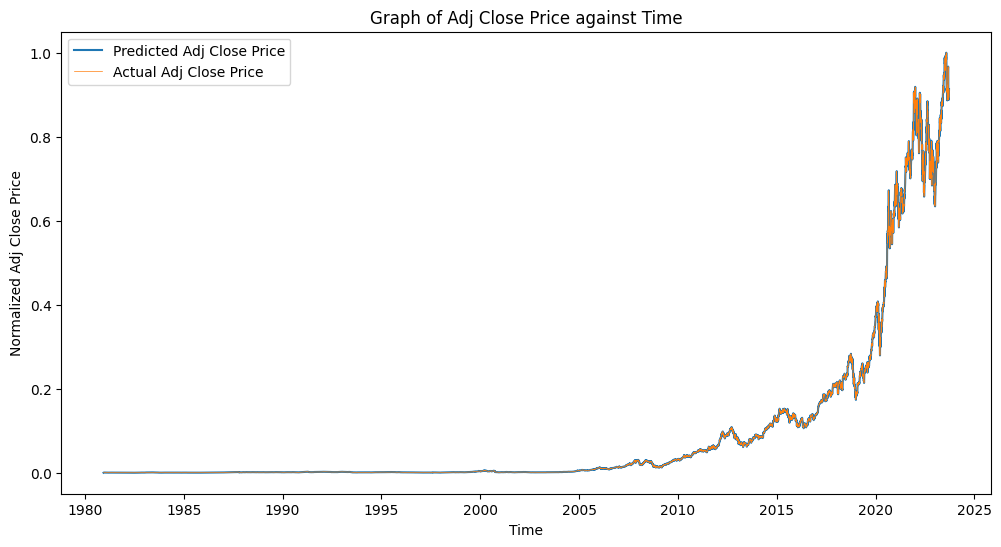

In [62]:
# Plot the graph of predictions and actual values of Adj Close Price
plt.figure(figsize=(12, 6))
plt.title("Graph of Adj Close Price against Time")
plt.plot(y_pred, label="Predicted Adj Close Price")
plt.plot(df_scaled[endog_variable], label="Actual Adj Close Price", lw=0.5)
plt.xlabel("Time")
plt.ylabel("Normalized Adj Close Price")
plt.legend()
plt.show()

I then trained an ARIMA model using a Rolling Window, where future data is appended to current data, and used to train and predict data.

In [76]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
y_pred = []

endog_variable = "Adj Close"
time_step = 360
history = pd.DataFrame()
# Base model, to be trained and updated
model = None
# Update the model every 360 days
print(len(df_scaled))
for i in range(0, len(df_scaled), time_step):    
    print(f"Training using batch of 360 days starting from {df_scaled.index[i].date()}")    
    history = pd.concat([history, df_scaled.iloc[i:i+time_step]])
    model = ARIMA(endog=history[endog_variable], order = (1,1,1))
    model_fit = model.fit()   
    
model_fit = model.fit()
print(model_fit.summary())
y_pred_rolling = model_fit.predict(start=start, end=end, dynamic=False)
error = mean_squared_error(y_pred_rolling, df_scaled[endog_variable])
print(f'Train MSE: {error}')

15623
Training using batch of 360 days starting from 1980-12-12
Training using batch of 360 days starting from 1981-12-07
Training using batch of 360 days starting from 1982-12-02
Training using batch of 360 days starting from 1983-11-27
Training using batch of 360 days starting from 1984-11-21
Training using batch of 360 days starting from 1985-11-16
Training using batch of 360 days starting from 1986-11-11
Training using batch of 360 days starting from 1987-11-06
Training using batch of 360 days starting from 1988-10-31
Training using batch of 360 days starting from 1989-10-26
Training using batch of 360 days starting from 1990-10-21
Training using batch of 360 days starting from 1991-10-16
Training using batch of 360 days starting from 1992-10-10
Training using batch of 360 days starting from 1993-10-05
Training using batch of 360 days starting from 1994-09-30
Training using batch of 360 days starting from 1995-09-25
Training using batch of 360 days starting from 1996-09-19
Training

## Hyperparameter Tuning (p, d, q)

In [118]:
model = auto_arima(df_scaled[endog_variable], seasonal=False, trace=True,
                   error_action='ignore', suppress_warnings=True)
model.fit(df_scaled[endog_variable])

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-134768.103, Time=27.36 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-124773.995, Time=1.58 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-129050.165, Time=2.61 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-132896.400, Time=7.94 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-124776.082, Time=0.85 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=35.37 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-132808.609, Time=12.48 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-134963.510, Time=30.22 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-132254.505, Time=16.40 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=-116691.214, Time=59.54 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-134388.665, Time=25.59 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-134216.846, Time=25.63 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-133298.576, Time=28.52 sec
 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=-134724.529, Time

In [92]:
# Splitting the data into training and testing (70% training, 30% testing)
train_size = int(0.7 * len(df_scaled))
train, test = df_scaled[:train_size], df_scaled[train_size:]

print("train")
print(train)
print("test")
print(test)

train
                Open      High       Low     Close  Adj Close    Volume
1980-12-12  0.000401  0.000400  0.000406  0.000403   0.000313  0.063198
1980-12-13  0.000391  0.000389  0.000394  0.000392   0.000304  0.050032
1980-12-14  0.000380  0.000377  0.000383  0.000381   0.000295  0.036865
1980-12-15  0.000370  0.000366  0.000372  0.000369   0.000287  0.023699
1980-12-16  0.000324  0.000321  0.000326  0.000324   0.000251  0.014246
...              ...       ...       ...       ...        ...       ...
2010-11-16  0.055400  0.055182  0.054504  0.054592   0.046416  0.088612
2010-11-17  0.054577  0.054532  0.054219  0.054394   0.046248  0.064602
2010-11-18  0.055305  0.055555  0.055487  0.055836   0.047473  0.066628
2010-11-19  0.055809  0.055326  0.055587  0.055527   0.047211  0.051854
2010-11-20  0.055731  0.055624  0.055626  0.055929   0.047552  0.052224

[10936 rows x 6 columns]
test
                Open      High       Low     Close  Adj Close    Volume
2010-11-21  0.055653  0.055

### Perform Training using Training data

In [135]:
model = ARIMA(train[endog_variable], order=(3,1,2))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                15466
Model:                 ARIMA(3, 1, 2)   Log Likelihood               67511.404
Date:                Thu, 21 Sep 2023   AIC                        -135010.809
Time:                        18:16:55   BIC                        -134964.931
Sample:                    12-12-1980   HQIC                       -134995.610
                         - 04-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       1.682e-09      0.001   1.78e-06      1.000      -0.002       0.002
ar.L2       2.576e-10      0.001    2.2e-07      1.000      -0.002       0.002
ar.L3      -3.362e-10      0.003  -1.16e-07      1.000      -0.006       0.006
ma.L1       1.681e-09      0.001   1.77e-06      1.000      -0.002       0.002
ma.L2       2.567e-10      0.001    2.2e-07      1.000      -0.002       0.002
sigma2      9.438e-06   1.76e-08    537.167      0.000     9.4e-06    9.47e-06
===================================================================================
Ljung-Box (L1) (Q):                   5.43   Jarque-Bera (JB):           4253296.63
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):           40571.72   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        84.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+17. Standard errors may be unstable.
"""

### Perform Predictions on test data

In [136]:
y_pred = model_fitted.forecast(steps=len(test))
y_pred

2023-04-17    0.839852
2023-04-18    0.839852
2023-04-19    0.839852
2023-04-20    0.839852
2023-04-21    0.839852
                ...   
2023-09-16    0.839852
2023-09-17    0.839852
2023-09-18    0.839852
2023-09-19    0.839852
2023-09-20    0.839852
Freq: D, Name: predicted_mean, Length: 157, dtype: float64

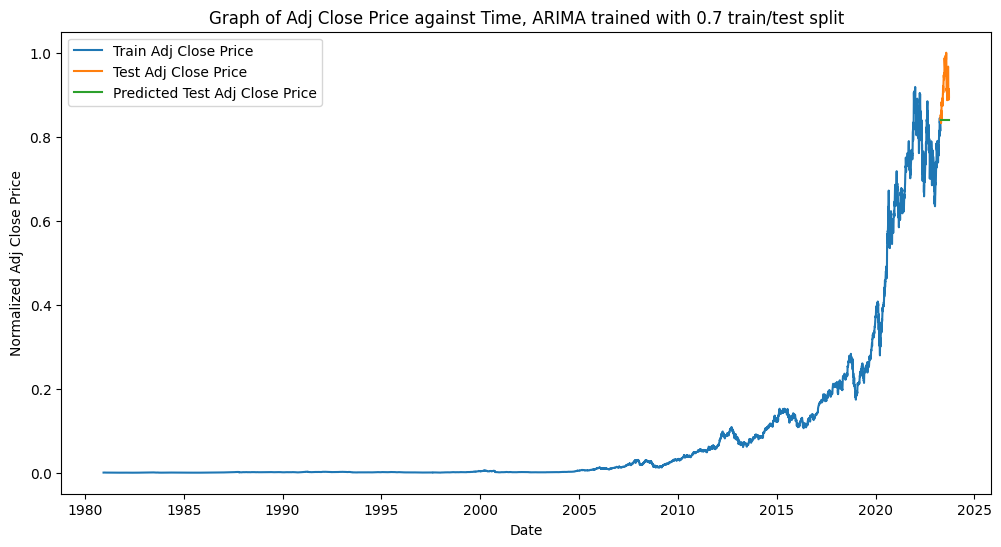

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(train[endog_variable], label = "Train Adj Close Price")
plt.plot(test[endog_variable], label = "Test Adj Close Price")
plt.plot(y_pred, label = "Predicted Test Adj Close Price")
plt.title("Graph of Adj Close Price against Time, ARIMA trained with 0.7 train/test split")
plt.xlabel("Date")
plt.ylabel("Normalized Adj Close Price")
plt.legend()
plt.show()

Test Mean Squared Error is: 0.3657483053924655


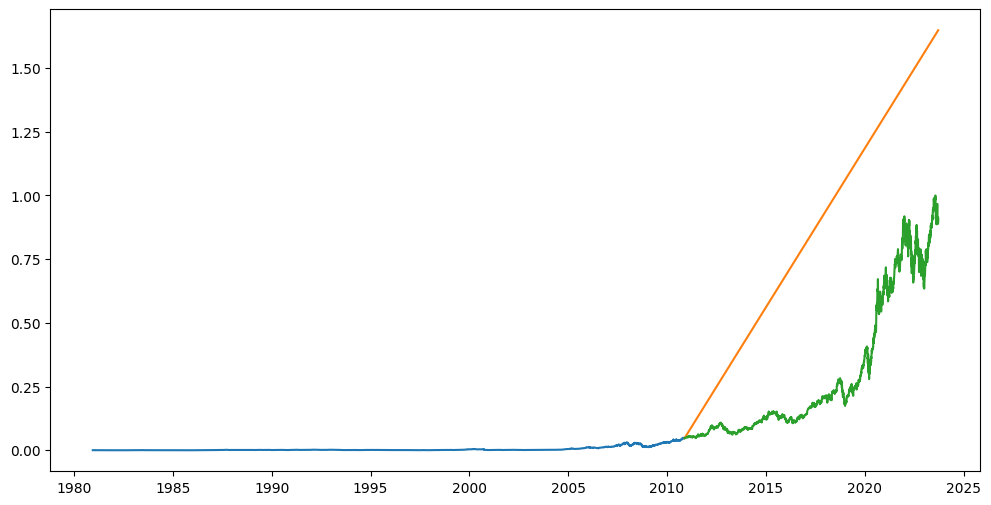

Test Mean Squared Error is: 0.2554038683988082


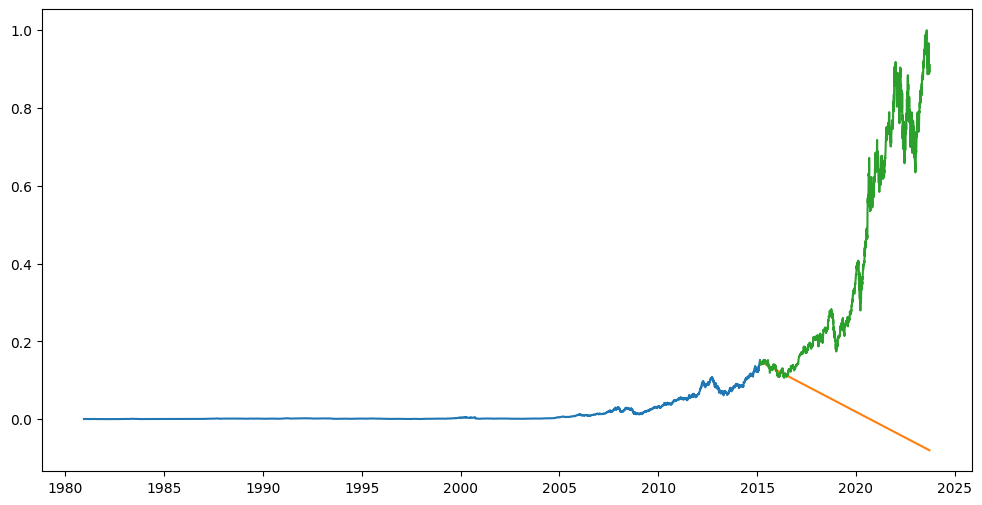

Test Mean Squared Error is: 0.2198343222067984


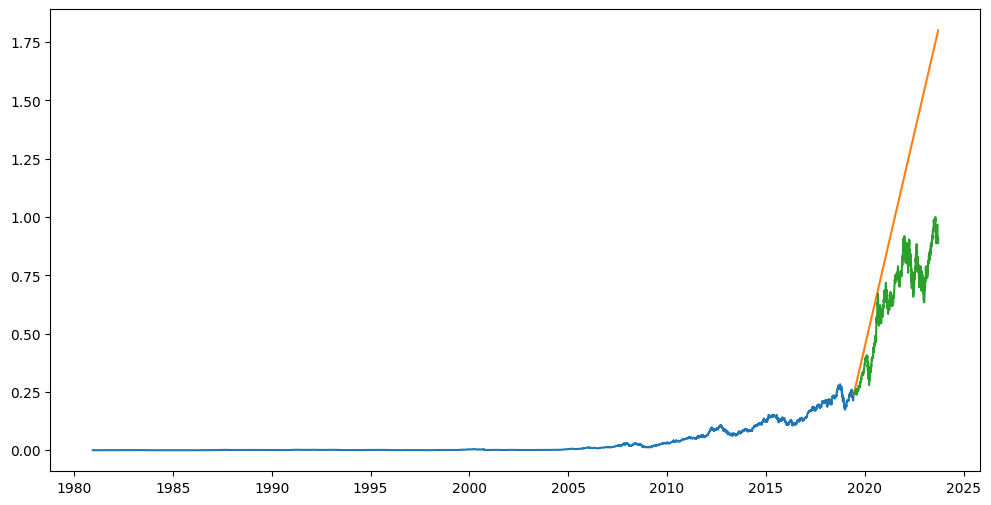

Test Mean Squared Error is: 0.03895595902197557


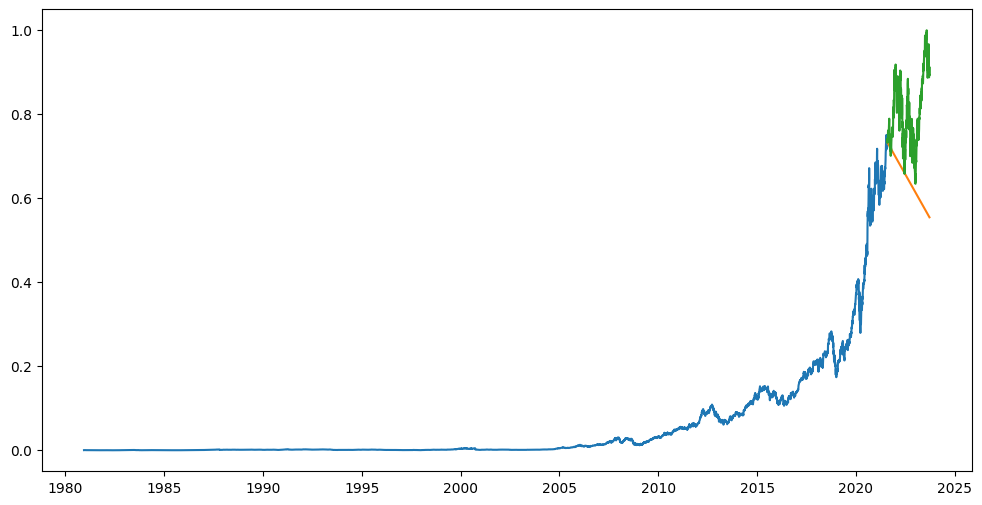

Test Mean Squared Error is: 0.007956839306393898


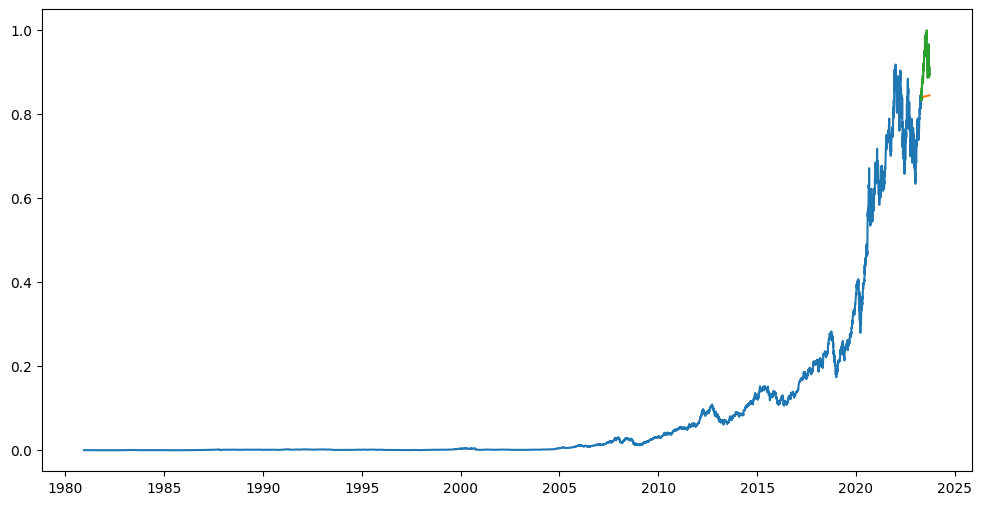

In [123]:
endog_variable = "Adj Close"
def train_test_split(data, r):
    # Splitting the data into training and testing (r training, 1-r testing)
    train_size = int(r * len(data))
    train, test = data[:train_size], data[train_size:]
    return train, test

def get_predictions(train, test):
    # Train Model: Fixed Parameters for now
    model = ARIMA(train[endog_variable], order=(3,2,2))
    model_fitted = model.fit()
    
    # Predict using Test Data
    y_pred = model_fitted.forecast(steps=len(test))
    return y_pred

# Can evaluate using other metrics as well
def evaluate(y_pred, y):
    mse = mean_squared_error(y_pred, y)
    print(f"Test Mean Squared Error is: {mse}")

def visualise(y_pred, y):
    plt.figure(figsize=(12,6))
    plt.plot(train[endog_variable], label = "Train Adj Close Price")
    plt.plot(y_pred)
    plt.plot(y)
    plt.show()
for r in [0.7,0.8,0.9,0.95,0.99]:
    train, test = train_test_split(df_scaled, r)
    pred = get_predictions(train, test)
    evaluate(pred, test[endog_variable])
    visualise(pred, test[endog_variable])

## Model Evaluation
Some code to evaluate the performance of the model.

<Figure size 2000x600 with 0 Axes>

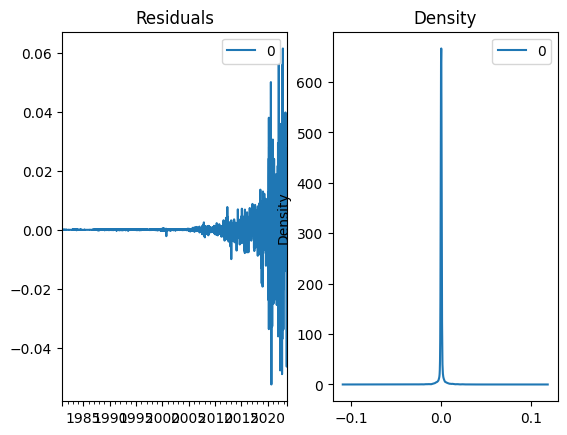

In [140]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(20, 6))
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## Summary
### Pros: 
- Model is quick to train, can handle relatively large amounts of data
- General direction of next-day predictions correct
- Could potentially achieve better future predictions using hyperparameter tuning
- Few parameters (p,d,q) to tune

### Cons:
- Unable to iteratively improve the model upon receiving new data (requires training a new model - Computationally expensive)
- Predicts a single response variable, potentially need multiple models to predict different features
- Regression model - need to deal with multicollinearity


AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'